In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np
import csv
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import cv2
from PIL import Image

from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, perimeter
from skimage import measure, morphology
from skimage import util

import h5py
import zipfile
from net_detector import *

/home/lavleen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lavleen/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_itk_image(filename):
    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)
    #numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    #numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    #print(itkimage)
    return numpyImage #numpyOrigin#, numpySpacing, numpyImage

In [3]:
def readCSV(filename):
    lines = []
    with open(filename, "r") as f:
        csvreader = csv.reader(f)
        for line in csvreader:
            lines.append(line)
    return lines

In [4]:
def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [5]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [6]:
def resize_image(numpyImage, numpySpacing):
    #calculate resize factor
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = numpySpacing / RESIZE_SPACING
    new_real_shape = numpyImage.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / numpyImage.shape
    new_spacing = numpySpacing / real_resize
    
    new_img = scipy.ndimage.interpolation.zoom(numpyImage, real_resize)
    #print(new_img.shape)
    
    return new_img, new_spacing

In [7]:
def image_preprocess(slice):
    
    kernel = np.ones((3,3),np.uint8)
    lung_img = np.array(slice < 604, dtype=np.uint8)                             #Thresholds the image properly - keeping
    #(ret_val,lung_img) = cv2.threshold(slice, -700, -600,cv2.THRESH_BINARY)       #Does not get rid of table marks - removing
    median = cv2.medianBlur(lung_img,5)                                        #To remove salt & pepper noise(Median blur better than Gaussian - preserves edges)
    opening = cv2.morphologyEx(median, cv2.MORPH_OPEN, kernel) #lung_img, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    cleared = clear_border(closing)   #opening) #
    labeled = label(cleared)

    #Select the 2 regions with largest areas
    areas = [r.area for r in regionprops(labeled)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(labeled):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       labeled[coordinates[0], coordinates[1]] = 0
    segmented = np.array(labeled > 0, dtype=np.uint8)
    segmented = cv2.morphologyEx(segmented, cv2.MORPH_CLOSE, kernel)             #Clean the areas inside lungs
    
    get_high_vals = segmented == 0
    slice[get_high_vals] = 0
    
    #Visualization
    #x, y = plt.subplots(1, 4, figsize=[20,20])
    #y[0].set_title('Original Binary Image')
    #y[0].imshow(lung_img, plt.cm.bone)
    #y[1].set_title('Denoised Image')
    #y[1].imshow(cleared, plt.cm.bone)
    #y[2].set_title('Labeled Image')
    #y[2].imshow(segmented, plt.cm.bone)
    #y[3].set_title('Segmented lungs')
    #y[3].imshow(slice, plt.cm.bone)
    #plt.show()
    
    return slice

In [8]:
def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([image_preprocess(slice) for slice in ct_scan])

In [9]:
#cands = readCSV(anno_path) #cand_path)

def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    #print(n)
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])
    
def draw_circles(image,cands,origin,spacing, filename):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ix, ca in enumerate(cands):
        if ca[0] == filename:              #'1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492':
            #print(ca)
            #print(image)#(ca[4])
            #get middel x-,y-, and z-worldcoordinate of the nodule
            radius = np.ceil(float(ca[4]))/2
            #print(radius)
            coord_x = float(ca[1])
            coord_y = float(ca[2])
            coord_z = float(ca[3])
            image_coord = np.array((coord_z,coord_y,coord_x))
            #print(image_coord)

            #determine voxel coordinate given the worldcoordinate
            #print(image_coord, type(image_coord))
            #print(origin, type(origin))
            #print(spacing, type(spacing))
            image_coord = worldToVoxelCoord(image_coord,origin,spacing)

            #determine the range of the nodule
            noduleRange = seq(-radius, radius, RESIZE_SPACING[0])
            #print(noduleRange)
            #create the mask
            for x in noduleRange:
                for y in noduleRange:
                    for z in noduleRange:
                        coords = worldToVoxelCoord(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                        #print(coords, coords[0], coords[1], coords[2])
                        #if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        try:
                            image_mask[int(np.round(coords[0])), int(np.round(coords[1])), int(np.round(coords[2]))] = int(1)
                        except:
                            pass
                        #print(image_mask.shape)
    return image_mask


In [10]:
os.listdir('/media/demcare/1T_Storage/lavleen/lavleen/lung_masks/')

['.ipynb_checkpoints', 'lung_masks.h5']

In [16]:
def hdf5_list_files(name):
    list_files.append(name)

list_files = []
train_data = []
train_origins = []
train_spacings = []

#dirc = os.listdir('./numpyimages/')
#print(dirc)
#for sset in dirc:
#pth = '/media/demcare/1T_Storage/lavleen/lavleen/numpyimages_test/subset7.h5' #+str(sset)
pth = './numpyimages_test/subset7.h5'
#print(pth)
read_train = h5py.File(pth, 'r')#'HDF5//subset0.h5','r')
read_train.visit(hdf5_list_files)
train_data.append(read_train)

pth_o = './numpyorigins_test/subset7_origin.h5' #+str(sset)
read_train_origin = h5py.File(pth_o, 'r')#'HDF5//subset0_origin.h5', 'r')
train_origins.append(read_train_origin)

pth_s = './numpyspacing_test/subset7_spacing.h5' #+str(sset)
read_train_space = h5py.File(pth_s, 'r')#'HDF5//subset0_spacing.h5', 'r')
train_spacings.append(read_train_space)

#f.close()

In [15]:
print(train_data)
for file in train_data:
    if '1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd' in file:
        print(file)
        print(file['1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd'].value)

[<HDF5 file "subset0.h5" (mode r)>]
<HDF5 file "subset0.h5" (mode r)>
[[[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 ..., 
 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 

In [17]:
print(len(list_files))

89


In [18]:
import math

/home/lavleen/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:58: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True
/home/lavleen/anaconda3/lib/python3.6/site-packages/skimage/segmentation/_clear_border.py:60: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  borders[slicedim] = True


TypeError: Invalid dimensions for image data

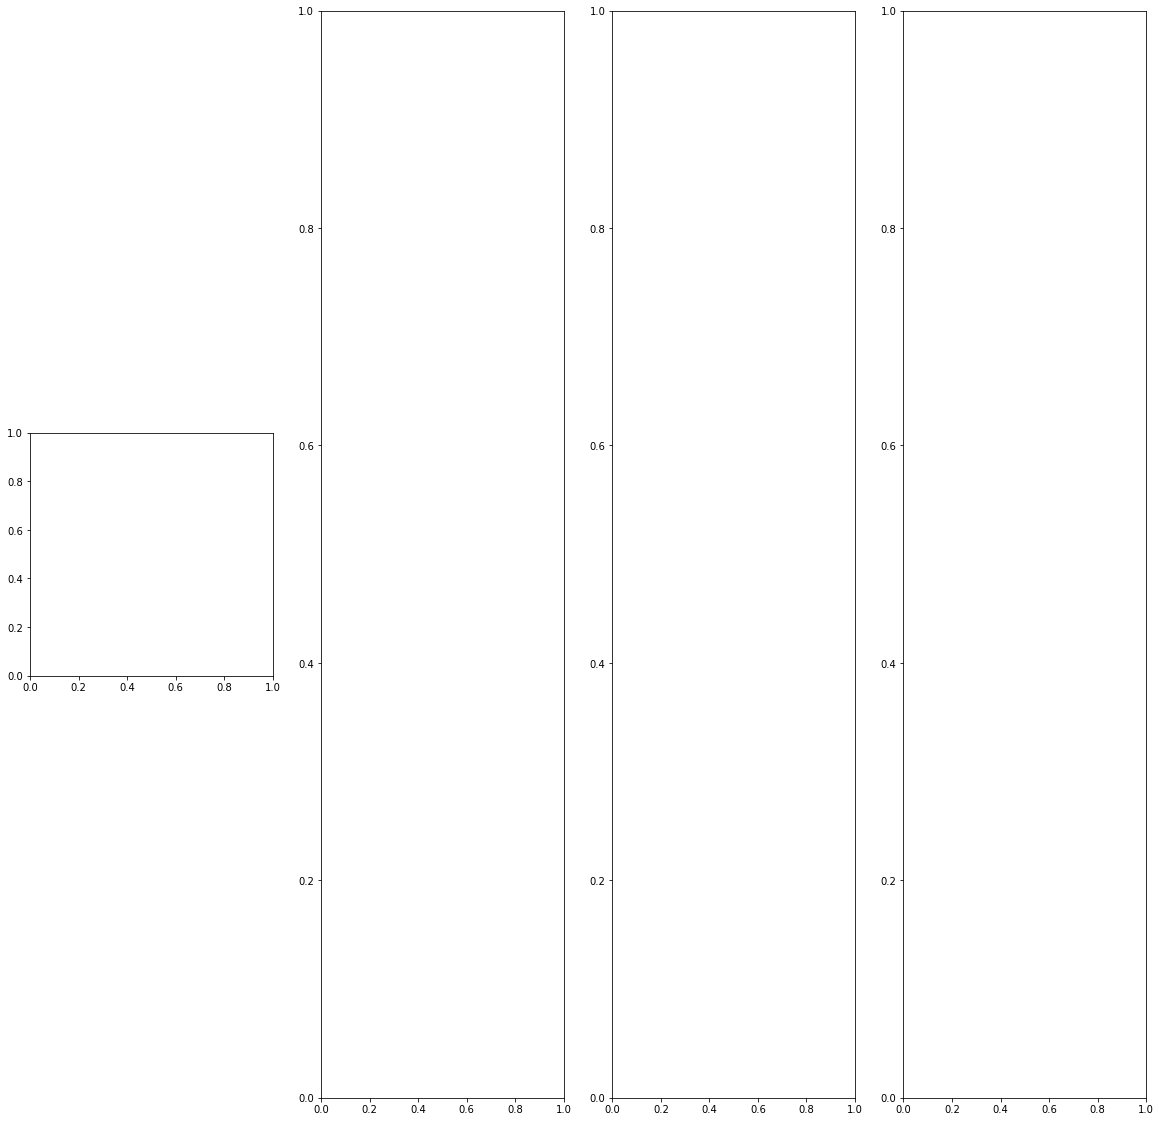

In [19]:
anno_path = "annotations.csv"
h5f_lungs = h5py.File('/media/demcare/1T_Storage/lavleen/lavleen/lung_masks/lung_masks.h5', 'a')
h5f_nod = h5py.File('/media/demcare/1T_Storage/lavleen/lavleen/nodule_masks/nodule_masks.h5', 'a')


def full_preprocessing(anno_path):
    cands = readCSV(anno_path)
    #Now, for multiple images
    files_already_read = []
    count = 0
       
    for filename in list_files:
        if filename not in files_already_read:# and filename[:-4] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492':
            files_already_read.append(str(filename))
            #print(filename)

            #img_path = '../input/subset0/subset0/subset0/' + str(filename[:-4]) + '.mhd'
            #print(img_path)
            #numpyImage, numpyOrigin, numpySpacing = load_itk_image(img_path)
            for file in train_data:
                if filename in file:
                    numpyImage = file[filename].value
                    
            for file in train_origins:
                if filename in file:
                    numpyOrigin = file[filename].value
                    
            for file in train_spacings:
                if filename in file:
                    numpySpacing = file[filename].value
            
            #Discard 20 slices from both ends
            #print(numpyImage.shape)
            #print(len(numpyImage))
            #numpyImage = numpyImage[20:120,:,:]
            #print(numpyImage.shape)

            #print(len(new_imga))
            #Resize the image before preprocessing
            resized_img, new_spacing = resize_image(numpyImage, numpySpacing)
            #print(resized_img.shape)
            resized_img = resized_img[20:270,:,:]
            #print(numpyImage.shape)
            #Pre-process the image
            numpyImage = resized_img + 1024
            processed_img = segment_lung_from_ct_scan(numpyImage)
            numpyImage = processed_img - 1024

            #create nodule mask
            nodule_mask = draw_circles(numpyImage,cands,numpyOrigin,new_spacing, str(filename[:-4]))

            lung_img_512, nodule_mask_512 = np.zeros((numpyImage.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

            original_shape = numpyImage.shape
            for z in range(numpyImage.shape[0]):
                offset = (512 - original_shape[1])
                upper_offset = int(np.round(offset/2))
                lower_offset = int(offset - upper_offset)
                #print(z, upper_offset, lower_offset)
                new_origin = voxel_2_world([-upper_offset,-lower_offset,0],numpyOrigin,new_spacing)
                #print(numpyImage.shape)
                #print(nodule_mask.shape)
                lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = numpyImage[z,:,:]
                nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]

            # save images.    
            #np.save('./lung_masks/' + str(filename[:-4]) + '_lung_img.npz', lung_img_512)
            #np.save('./nodule_masks/' + str(filename[:-4]) + '_nodule_mask.npz', nodule_mask_512)

            try:
                h5f_lungs.create_dataset(str(filename[:-4])+'.npz', data=lung_img_512, compression='gzip')
                h5f_nod.create_dataset(str(filename[:-4]) + '.npz', data=nodule_mask_512, compression='gzip')
            except:
                pass

            count += 1
            print(count)
        else:
            continue

full_preprocessing(anno_path)
h5f_lungs.close()
h5f_nod.close()

In [10]:
import tflearn
from tflearn.layers.core import *
from tflearn.layers.conv import *
from tflearn.data_utils import *
from tflearn.layers.merge_ops import *
from tflearn.layers.normalization import *
from tflearn.layers.estimator import regression
from tflearn.helpers.trainer import *
from tflearn.optimizers import *
import tensorflow

def nodule_rpn():
    layer1 = input_data(shape=[None, 250, 512, 512, 1])         #batch size, X, Y, Z, channels
    layer1 = conv_3d(layer1, nb_filter=64, filter_size=3, strides=1, padding='same', activation='relu')
    layer1 = batch_normalization(layer1)
    #layer1 = dropout(layer1, keep_prob=0.8)
    layer1 = conv_3d(layer1, nb_filter=64, filter_size=3, strides=1, padding='same', activation='relu')
    #layer1 = batch_normalization(layer1)
    pool1 = max_pool_3d(layer1, kernel_size=2, strides=2)
    
    layer2 = conv_3d(pool1, nb_filter=128, filter_size=3, strides=1, padding='same', activation='relu')
    layer2 = dropout(layer2, keep_prob=0.8)
    layer2 = conv_3d(layer2, nb_filter=128, filter_size=3, strides=1, padding='same', activation='relu')
    pool2 = max_pool_3d(layer2, kernel_size=2, strides=2)

    layer3 = conv_3d(pool2, nb_filter=256, filter_size=3, strides=1, padding='same', activation='relu')
    layer3 = dropout(layer3, keep_prob=0.8)
    layer3 = conv_3d(layer3, nb_filter=256, filter_size=3, strides=1, padding='same', activation='relu')
    pool3 = max_pool_3d(layer3, kernel_size=2, strides=2)

    layer4 = conv_3d(pool3, nb_filter=512, filter_size=3, strides=1, padding='same', activation='relu')
    layer4 = dropout(layer4, keep_prob=0.8)
    layer4 = conv_3d(layer4, nb_filter=512, filter_size=3, strides=1, padding='same', activation='relu')
    pool4 = max_pool_3d(layer4, kernel_size=2, strides=2)

    layer5 = conv_3d(pool4, nb_filter=1024, filter_size=3, strides=1, padding='same', activation='relu')
    layer5 = dropout(layer5, keep_prob=0.8)
    layer5 = conv_3d(layer5, nb_filter=1024, filter_size=3, strides=1, padding='same', activation='relu')

    up6 = merge([conv_3d_transpose(layer5, nb_filter=2, filter_size=3, strides=1, output_shape=[32, 64, 64, 512], bias=False), layer4], mode='concat', axis=1) #output_shape=[250, 512, 512]
    layer6 = conv_3d(up6, nb_filter=512, filter_size=3, strides=1, padding='same', activation='relu')
    layer6 = dropout(layer6, keep_prob=0.8)
    layer6 = conv_3d(layer6, nb_filter=512, filter_size=3, strides=1, padding='same', activation='relu')

    up7 = merge([conv_3d_transpose(layer6, nb_filter=2, filter_size=3, strides=1, output_shape=[63,128,128,256], bias=False), layer3], mode='concat', axis=1)
    layer7 = conv_3d(up7, nb_filter=256, filter_size=3, strides=1, padding='SAME', activation='relu')
    layer7 = dropout(layer7, keep_prob=0.8)
    layer7 = conv_3d(layer7, nb_filter=256, filter_size=3, strides=1, padding='SAME', activation='relu')

    up8 = merge([conv_3d_transpose(layer7, nb_filter=2, filter_size=3, strides=1, output_shape=[125, 256, 256, 128], bias=False), layer2], mode='concat', axis=1)
    layer8 = conv_3d(up8, nb_filter=128, filter_size=3, strides=1, padding='SAME', activation='relu')
    layer8 = dropout(layer8, keep_prob=0.8)
    layer8 = conv_3d(layer8, nb_filter=128, filter_size=3, strides=1, padding='SAME', activation='relu')

    up9 = merge([conv_3d_transpose(layer8, nb_filter=2, filter_size=3, strides=1, output_shape=[250, 512, 512, 64], bias=False), layer1], mode='concat', axis=1)
    layer9 = conv_3d(up9, nb_filter=64, filter_size=3, strides=1, padding='SAME', activation='relu')
    layer9 = dropout(layer9, keep_prob=0.8)
    layer9 = conv_3d(layer9, nb_filter=64, filter_size=3, strides=1, padding='SAME', activation='relu')

    layer10 = conv_3d(layer9, nb_filter=1, filter_size=1, strides=1, activation='sigmoid')

    model = tflearn.DNN(layer10)
    
    return model

In [10]:
import keras
from keras.layers.convolutional import *
from keras.layers import Dropout, Input
from keras.layers import Conv3D, MaxPooling3D
from keras.layers import *
from keras.optimizers import SGD, Adam
from keras.models import Model


# change the loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


'''
The UNET model is compiled in this function.
'''
def unet_model():
    inputs = Input((1, 512, 512, 250)) #((1, 512, 512, 250))
    conv1 = Conv3D(64, kernel_size=3, strides=1, activation='relu', padding='same')(inputs)
    #conv1 = Dropout(0.2)(conv1)
    print(conv1._keras_shape)
    conv1 = Conv3D(64, kernel_size=3, strides=1, activation='relu', padding='same')(conv1)
    print(conv1._keras_shape)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2), dim_ordering="th")(conv1)
    print(pool1._keras_shape)

    conv2 = Conv3D(128, kernel_size=3, strides=1, activation='relu', padding='same')(pool1)
    print(conv2._keras_shape)
    #conv2 = Dropout(0.2)(conv2)
    conv2 = Conv3D(128, kernel_size=3, strides=1, activation='relu', padding='same')(conv2)
    print(conv2._keras_shape)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2), dim_ordering="th")(conv2)
    print(pool2._keras_shape)

    #conv3 = Conv3D(256, kernel_size=3, strides=3, activation='relu', padding='same')(pool2)
    #print(conv3._keras_shape)
    #conv3 = Dropout(0.2)(conv3)
    #conv3 = Conv3D(256, kernel_size=3, strides=3, activation='relu', padding='same')(conv3)
    #print(conv3._keras_shape)
    #pool3 = MaxPooling3D(pool_size=(2, 2, 2), dim_ordering="th")(conv3)
    #print(pool3._keras_shape)

    conv4 = Conv3D(256, kernel_size=3, strides=1, activation='relu', padding='same')(pool2)
    print(conv4._keras_shape)
    #conv4 = Dropout(0.2)(conv4)
    conv4 = Conv3D(64, kernel_size=3, strides=1, activation='relu', padding='same')(conv4)
    print(conv4._keras_shape)
    #pool4 = MaxPooling3D(pool_size=(2, 2, 2), dim_ordering="th")(conv4)

    #conv5 = Conv3D(1024, kernel_size=3, strides=3, activation='relu', padding='same')(pool4)
    #conv5 = Dropout(0.2)(conv5)
    #conv5 = Conv3D(1024, kernel_size=3, strides=3, activation='relu', padding='same')(conv5)
    
    #up6 = merge([UpSampling3D(size=(2, 2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    #conv6 = Conv3D(512, kernel_size=3, strides=3, activation='relu', padding='same')(up6)
    #conv6 = Dropout(0.2)(conv6)
    #conv6 = Conv3D(512, kernel_size=3, strides=3, activation='relu', padding='same')(conv6)

    #up7 = merge([UpSampling3D(size=(2, 2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    #conv7 = Conv3D(256, kernel_size=3, strides=3, activation='relu', padding='same')(up7)
    #conv7 = Dropout(0.2)(conv7)
    #conv7 = Conv3D(256, kernel_size=3, strides=3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling3D(size=(2, 2, 2), data_format='channels_first')(conv4), conv2], axis=1)
    conv8 = Conv3D(128, kernel_size=3, strides=1, activation='relu', padding='same')(up8)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv3D(32, kernel_size=3, strides=1, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling3D(size=(2, 2, 2), data_format='channels_first')(conv8), conv1], axis=1)
    conv9 = Conv3D(64, kernel_size=3, strides=1, activation='relu', padding='same')(up9)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv3D(64, kernel_size=3, strides=1, activation='relu', padding='same')(conv9)

    conv10 = Conv3D(1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.summary()
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model

Using TensorFlow backend.


In [11]:
def lung_files_list(name):
    lung_files.append(name)

def nod_files_list(name):
    nod_files.append(name)

lung_files = []
nod_files = []


pth_l = '/media/demcare/1T_Storage/lavleen/lavleen/lung_masks/lung_masks.h5'
#print(pth)
lung_train = h5py.File(pth_l, 'r')
lung_train.visit(lung_files_list)

pth_n = '/media/demcare/1T_Storage/lavleen/lavleen/nodule_masks/nodule_masks.h5'
nod_train = h5py.File(pth_n, 'r')
nod_train.visit(nod_files_list)


In [12]:
print(len(lung_files)), print(len(nod_train))

90
90


(None, None)

In [18]:
for file in lung_files:
    #print(file)
    #print(file[:64])
    filename = file[:64] + '.npz'
    print(lung_train[file].shape, nod_train[filename].shape)
    #break

(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(214, 512, 512) (214, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(240, 512, 512) (240, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 512, 512) (250, 512, 512)
(250, 51

In [12]:
# change the loss function
def dice_coef(y_pred, true):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_pred, y_true):
    return -dice_coef(y_pred, y_true)

In [12]:
def train_and_predict(use_existing):
    print('Loading and preprocessing train data...')
    count = 0
    imgs_train = []
    imgs_mask_train = []
    for file in lung_train:
        #filename = file[:64] + '_nodule_mask.npz'
        imgs_train.append((lung_train[file].value).astype(np.float32))
        imgs_mask_train.append((nod_train[file].value).astype(np.float32))
        count += 1
        if count == 51:
            break

    #imgs_test = np.load(img_path.split('/')[-1]+"testImages.npy").astype(np.float32)
    #imgs_mask_test_true = np.load(img_path.split('/')[-1]+"testMasks.npy").astype(np.float32)
    
    #mean = np.mean(imgs_train)  # mean for data centering
    #std = np.std(imgs_train)  # std for data normalization

    #imgs_train -= mean  # images should already be standardized, but just in case
    #imgs_train /= std

    
    print('Creating and compiling model...')
    
    model = unet_model() #nodule_rpn() #
    # Saving weights to unet.hdf5 at checkpoints
    model_checkpoint = model.save('./nodule_rpn.tfl')
    #
    # Should we load existing weights? 
    # Set argument for call to train_and_predict to true at end of script
    if use_existing:
        model.load('./nodule_rpn.tfl')
        
    # 
    # The final results for this tutorial were produced using a multi-GPU
    # machine using TitanX's.
    # For a home GPU computation benchmark, on my home set up with a GTX970 
    # I was able to run 20 epochs with a training set size of 320 and 
    # batch size of 2 in about an hour. I started getting reseasonable masks 
    # after about 3 hours of training. 
    #
    
    print('Fitting model...')
    #loss = tensorflow.losses.softmax_cross_entropy(imgs_train, imgs_mask_train)
    #train_ops = tflearn.TrainOp(loss=loss, optimizer=Adam(learning_rate=1e-4))#, metric=dice_coef)
    #trainer = tflearn.Trainer(train_ops=train_ops, tensorboard_verbose=0)
    #for file in lung_train:
    #    imgs_train = lung_train[file].value
    #    imgs_mask_train = nod_train[file].value
    #trainer.fit(imgs_train, imgs_mask_train, n_epoch=10, batch_size=2, shuffle=True, callbacks=[model_checkpoint]) # verbose=1, 
    for img in imgs_train:
        for mask in imgs_mask_train:
            x = img.shape[0]
            y = img.shape[1]
            z = img.shape[2]
            img = img.reshape((1, -1, z, y, x))
            x1 = mask.shape[0]
            y1 = mask.shape[1]
            z1 = mask.shape[2]
            mask = mask.reshape((1, -1,z1,y1,x1))
            if x == 250:
                model.fit(img, mask, epochs=5, batch_size=1, verbose=1, shuffle=True) #,  callbacks=[model_checkpoint]) # verbose=1, 
                break
    #train_ops=train_ops,
    # loading best weights from training session
    print('-'*30)
    print('Loading saved weights...')
    print('-'*30)
    model.load('./nodule_rpn.tfl')

    print('-'*30)
    #print('Predicting masks on test data...')
    print('-'*30)
    #num_test = len(imgs_test)
    #imgs_mask_test = np.ndarray([num_test,1,512,512],dtype=np.float32)
    #for i in range(num_test):
    #    imgs_mask_test[i] = model.predict([imgs_test[i:i+1]], verbose=0)[0]
    #np.save('masksTestPredicted.npy', imgs_mask_test)
    #mean = 0.0
    #for i in range(num_test):
    #    mean+=dice_coef_np(imgs_mask_test_true[i,0], imgs_mask_test[i,0])
    #mean/=num_test
    #print("Mean Dice Coeff : ",mean)

In [13]:
train_and_predict(False)

Loading and preprocessing train data...
Creating and compiling model...
(None, 1, 512, 512, 64)
(None, 1, 512, 512, 64)

/home/lavleen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:33: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), data_format="channels_first")`



(None, 1, 256, 256, 32)
(None, 1, 256, 256, 128)
(None, 1, 256, 256, 128)
(None, 1, 128, 128, 64)
(None, 1, 128, 128, 256)
(None, 1, 128, 128, 64)


/home/lavleen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: UserWarning: Update your `MaxPooling3D` call to the Keras 2 API: `MaxPooling3D(pool_size=(2, 2, 2), data_format="channels_first")`
/home/lavleen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:85: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 512, 512,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 1, 512, 512,  432064      input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 1, 512, 512,  110656      conv3d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling3d_1 (MaxPooling3D)  (None, 1, 256, 256,  0           conv3d_2[0][0]                   
__________________________________________________________________________________________________
conv3d_3 (

InvalidArgumentError: Incompatible shapes: [65011712] vs. [786432]
	 [[Node: metrics/dice_coef/mul = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](metrics/dice_coef/Reshape, metrics/dice_coef/Reshape_1)]]

Setup the HDF5 file server

To add images to the database

In [5]:
#h5f.close()
#Store numpy image to the hdf5 files
h5f = h5py.File('HDF5//subset2.h5', 'w')
files_path = 'C://Users//Ajitesh//Downloads//subset2'

list_files = os.listdir(files_path)

for filename in list_files:
    #Extract the file from ZIP folder directly to the server
    file = files_path + '//' + filename
    if 'mhd' in file:
        #print(file)
        h5f.create_dataset(filename, data=load_itk_image(file), compression='gzip')

h5f.close()

In [9]:
h5f.close()
#Store numpy image's origin to the hdf5 files
h5f = h5py.File('HDF5//subset2_origin.h5', 'w')
files_path = 'C://Users//Ajitesh//Downloads//subset2' #Practicum//subset0.zip'            #'../input/subset0/subset0/subset0'

list_files = os.listdir(files_path)

for filename in list_files:
    #Extract the file from ZIP folder directly to the server
    file = files_path + '//' + filename
    if 'mhd' in file:
        #print(file)
        h5f.create_dataset(filename, data=load_itk_image(file))

h5f.close()

In [6]:
#Store numpy image's spacing to the hdf5 files
h5f = h5py.File('HDF5//subset2_spacing.h5', 'w')
files_path = 'C://Users//Ajitesh//Downloads//subset2' #Practicum//subset0.zip'            #'../input/subset0/subset0/subset0'

list_files = os.listdir(files_path)

for filename in list_files:
    #Extract the file from ZIP folder directly to the server
    file = files_path + '//' + filename
    if 'mhd' in file:
        #print(file)
        h5f.create_dataset(filename, data=load_itk_image(file))

h5f.close()

In [4]:
print(list_files)

['1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.raw', '1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd', '1.3.6.1.4.1.14519.5.2.1.6279.6001.1261214600172571370987811435

Read the files

In [14]:
h5f_r = h5py.File('HDF5//subset0.h5', 'r')
#keys= list(h5f_r)
#print(keys)
image = h5f_r['1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd'].value

print(image)
#h5f_r.close()

[[[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]]

 ..., 
 [[-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  [-3024 -3024 -3024 ..., -3024 -3024 -3024]
  ..., 
  [-3024 -

In [6]:
for name in h5f_r:
    print(name)

subset0


/home/lavleen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


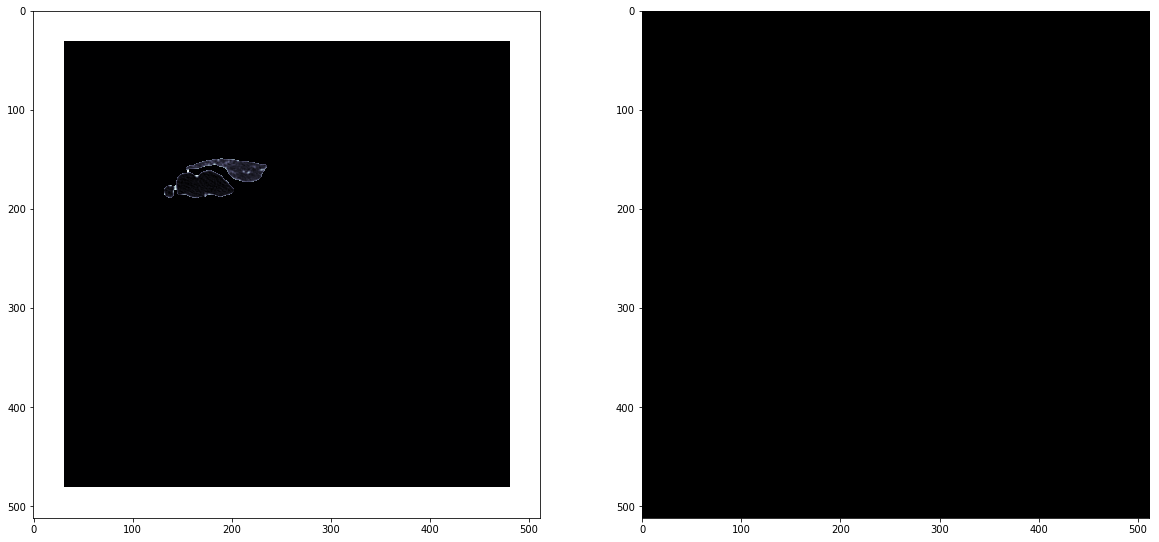

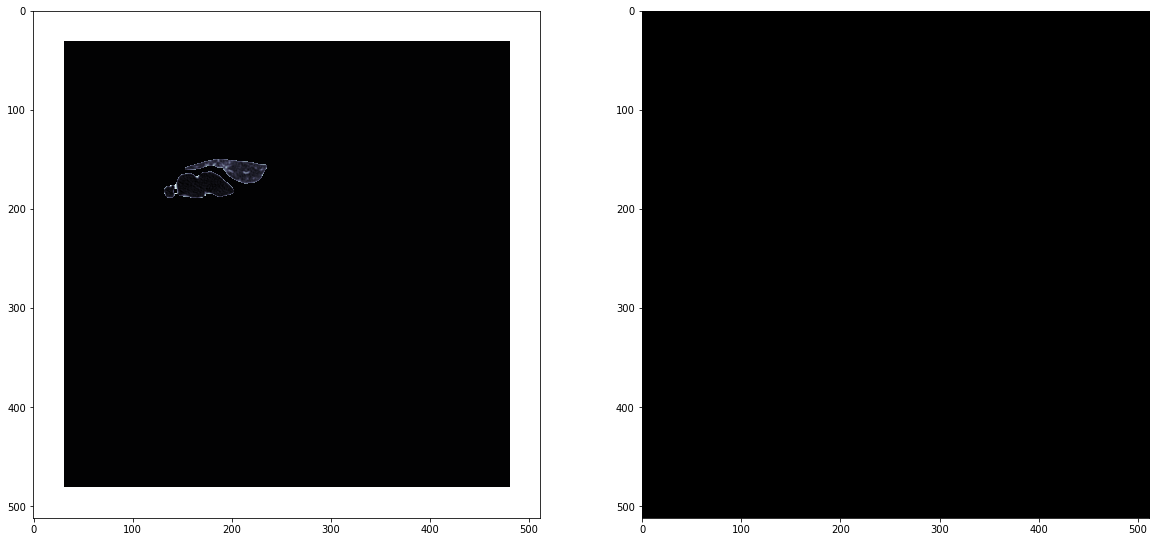

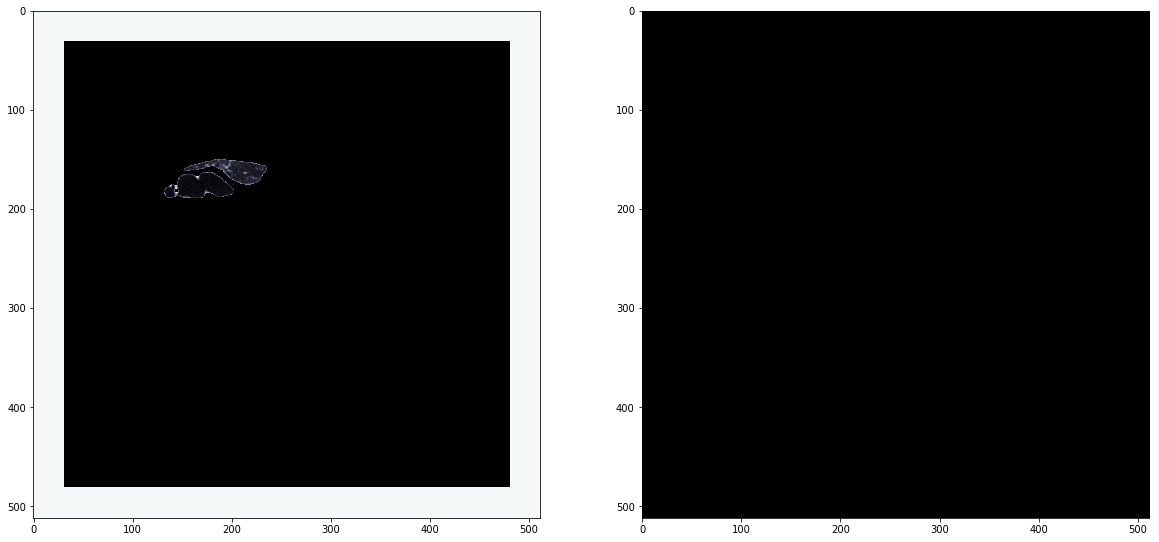

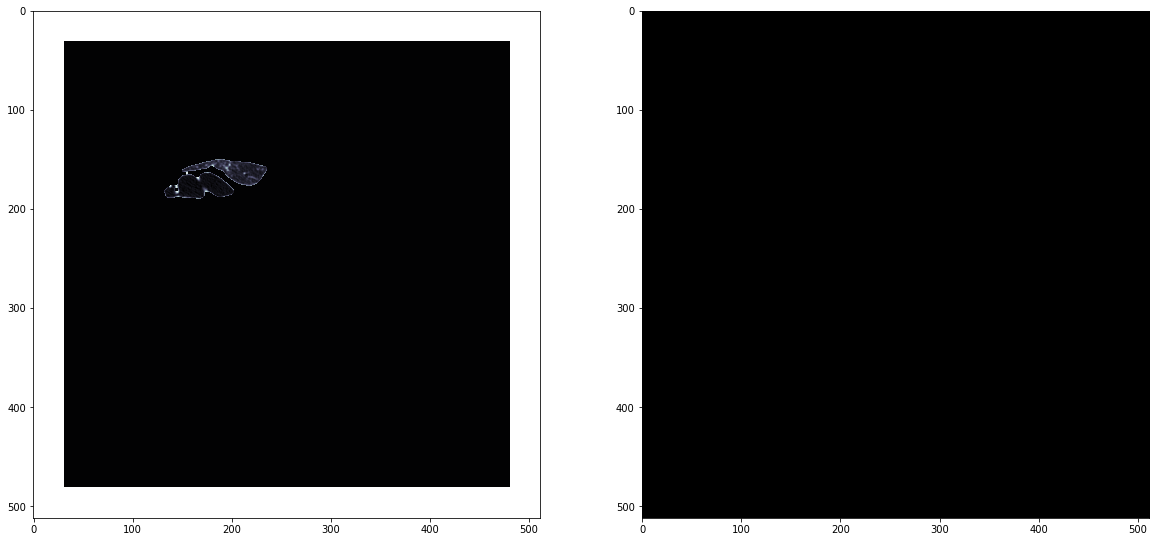

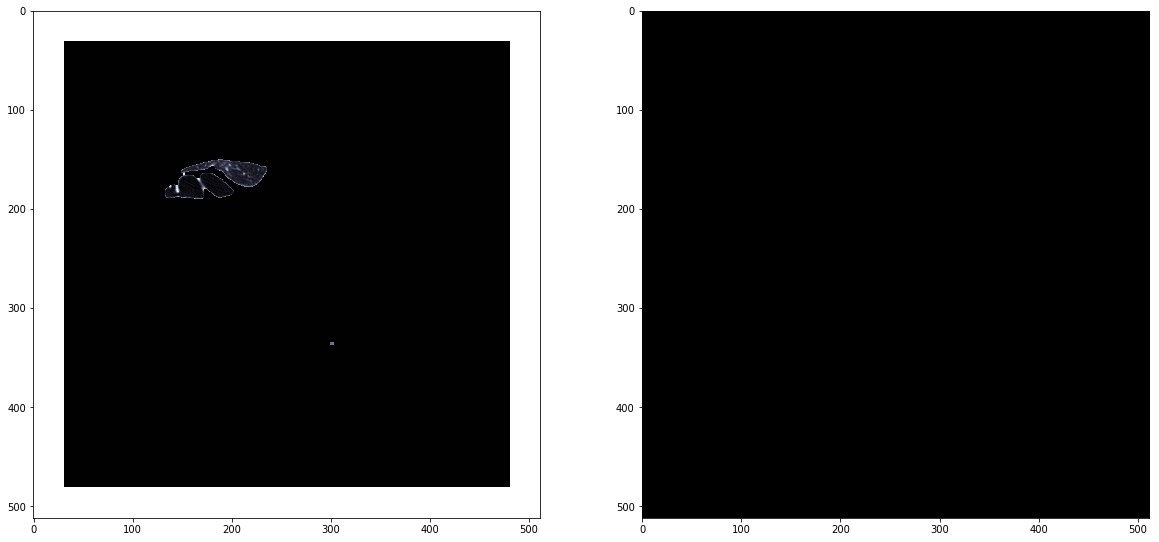

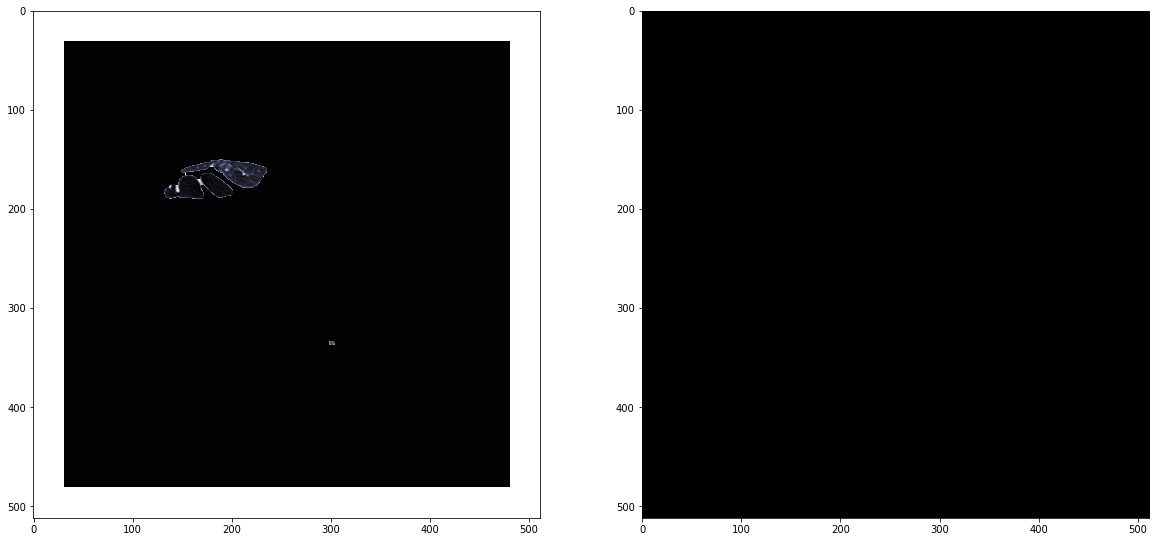

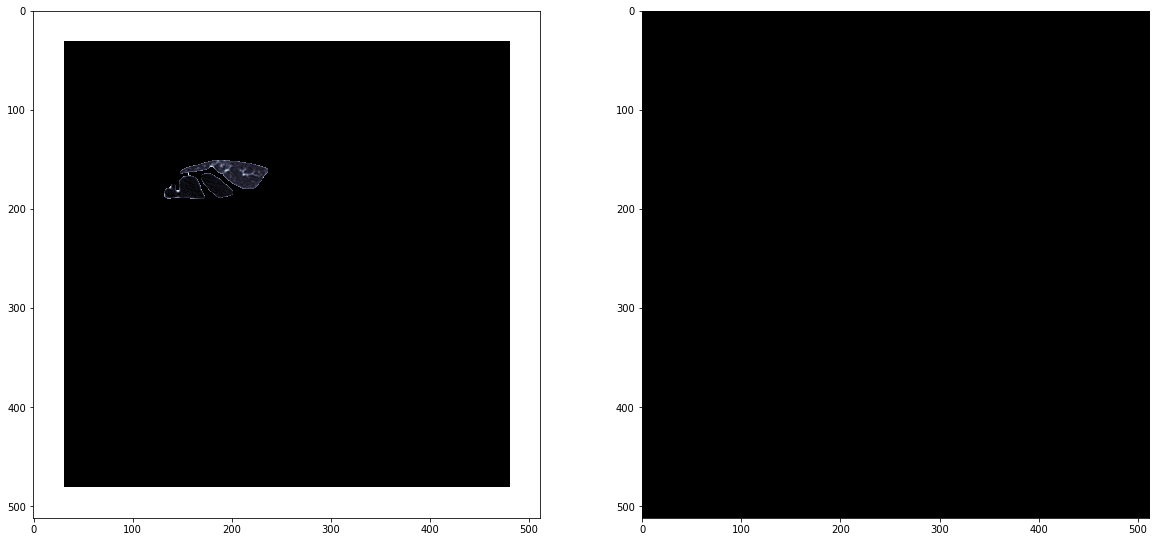

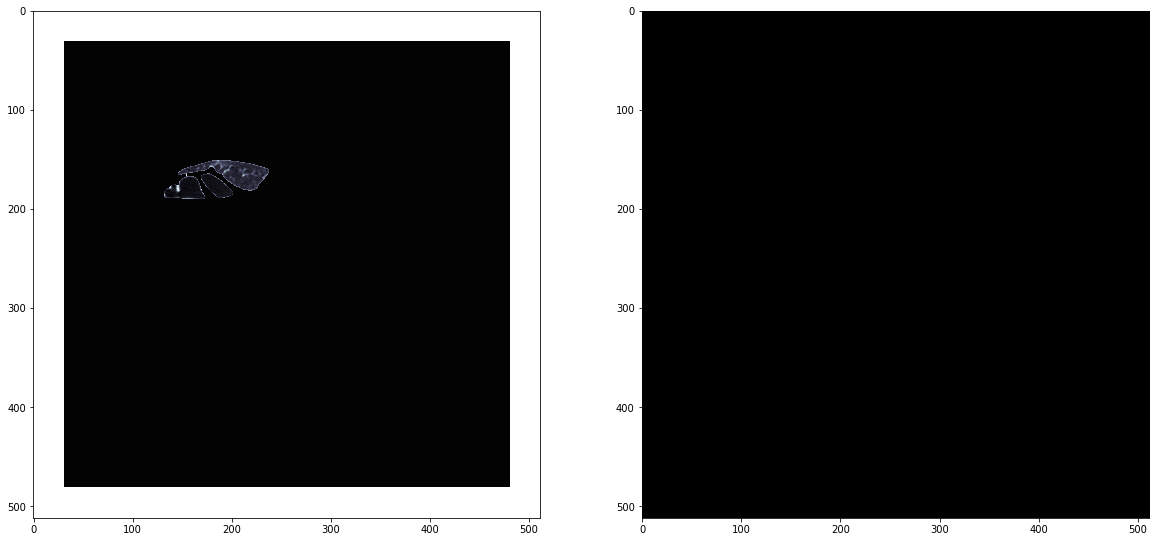

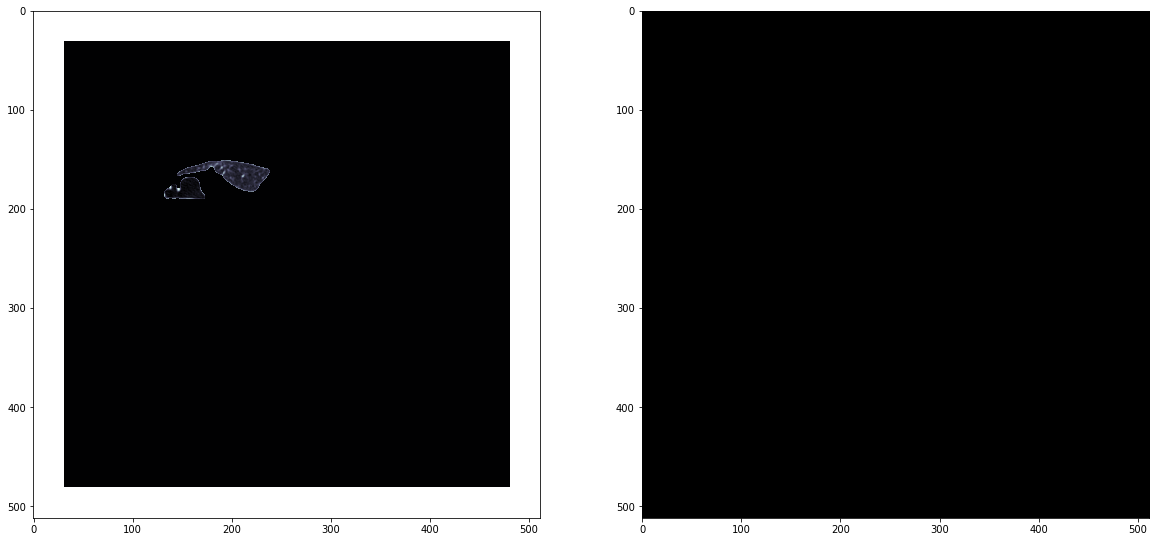

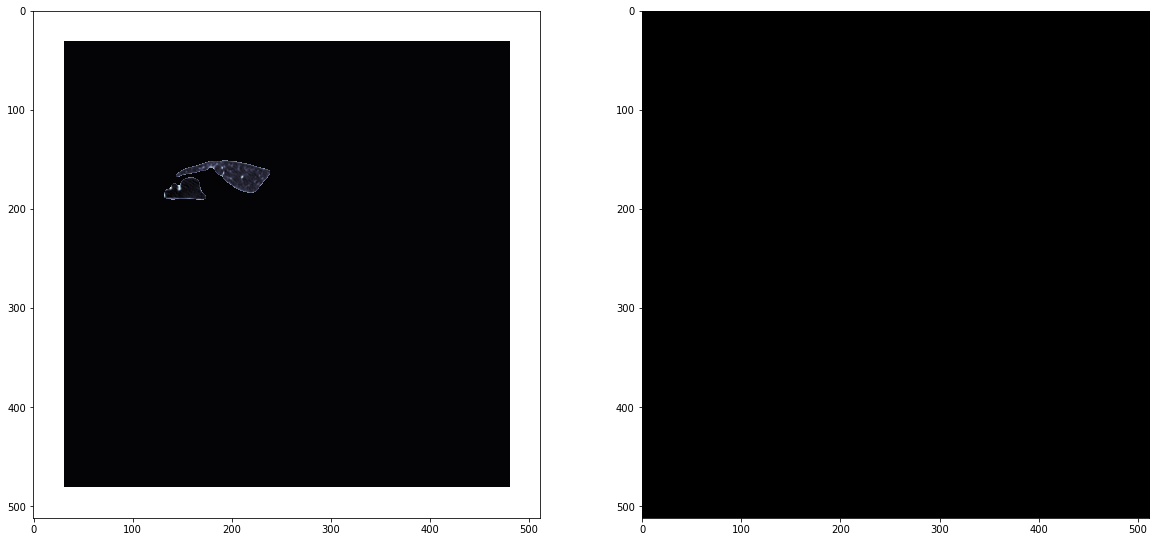

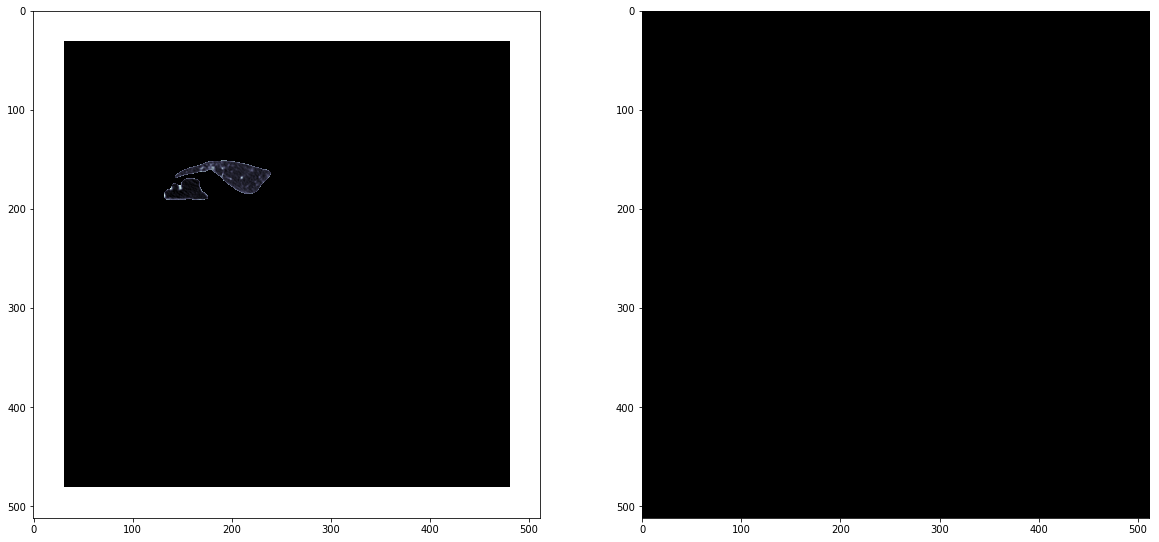

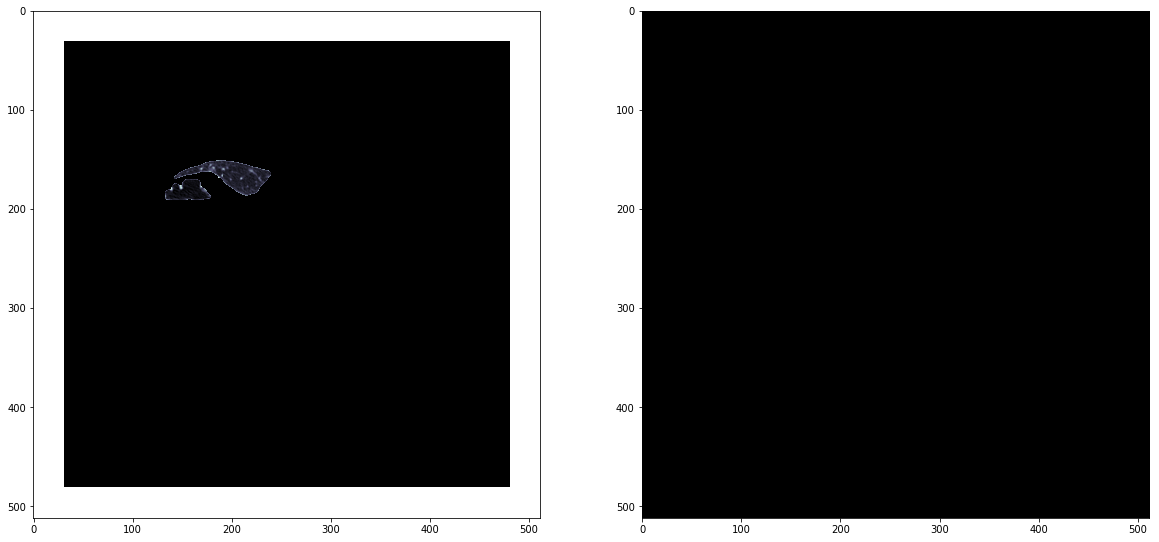

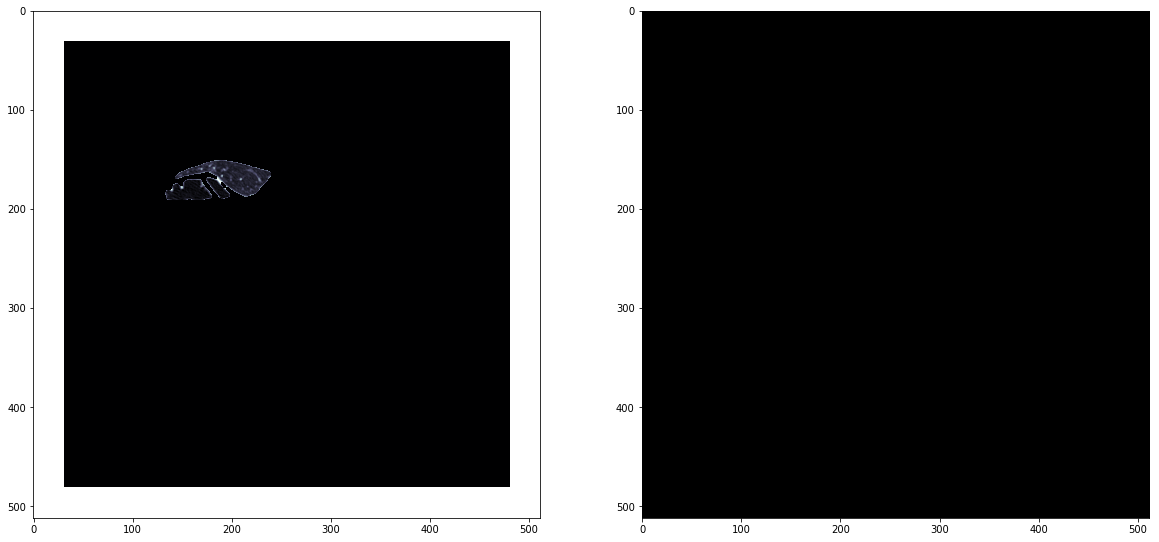

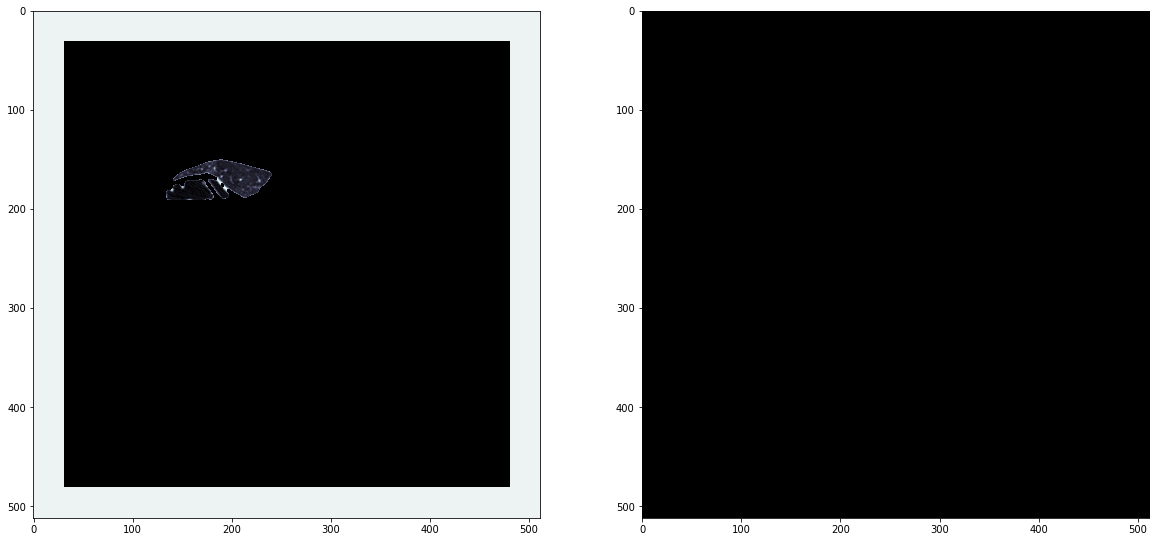

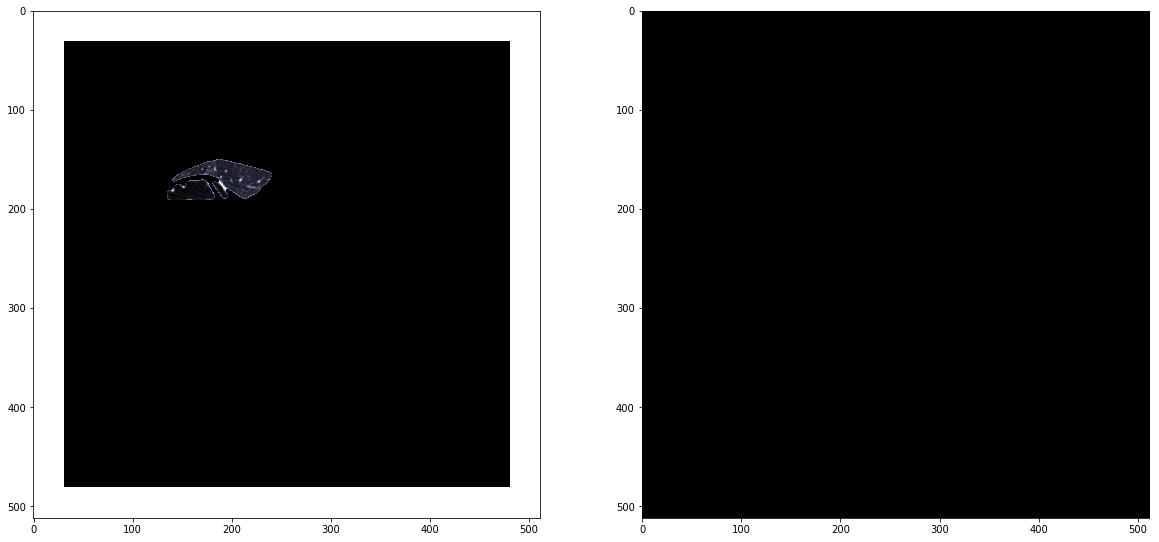

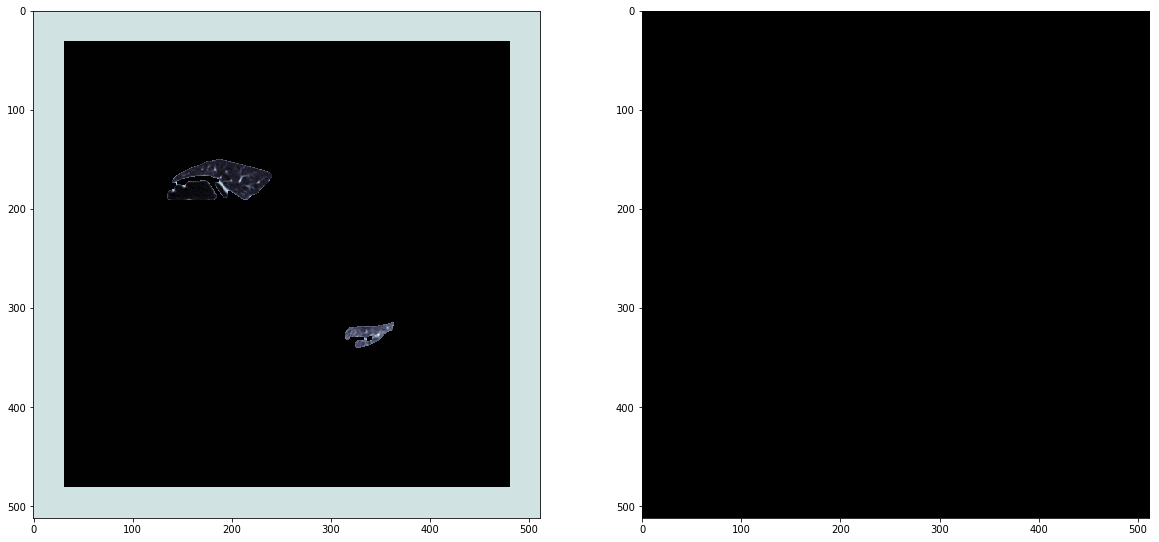

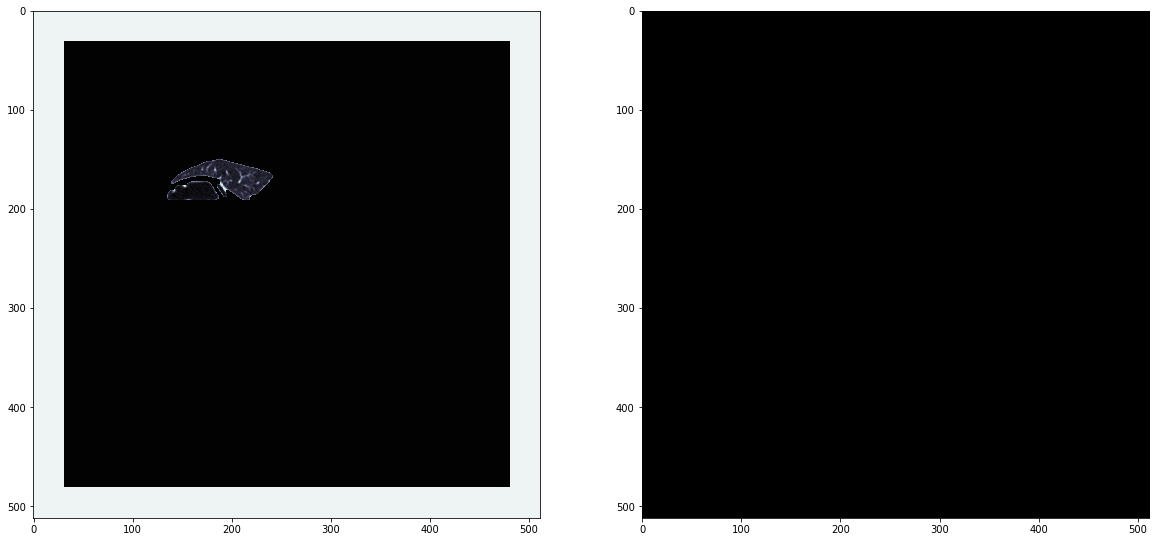

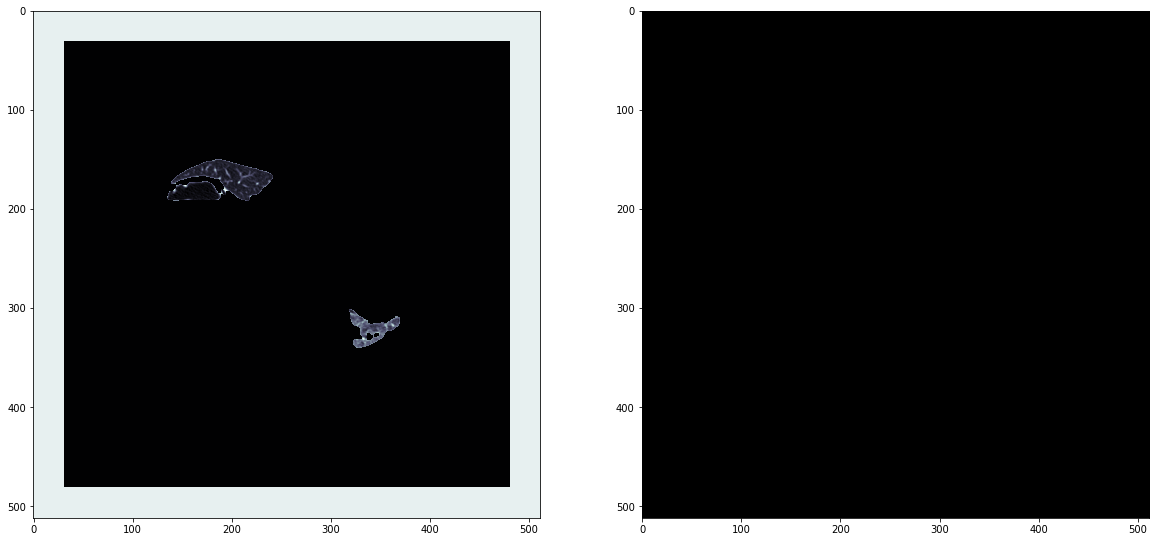

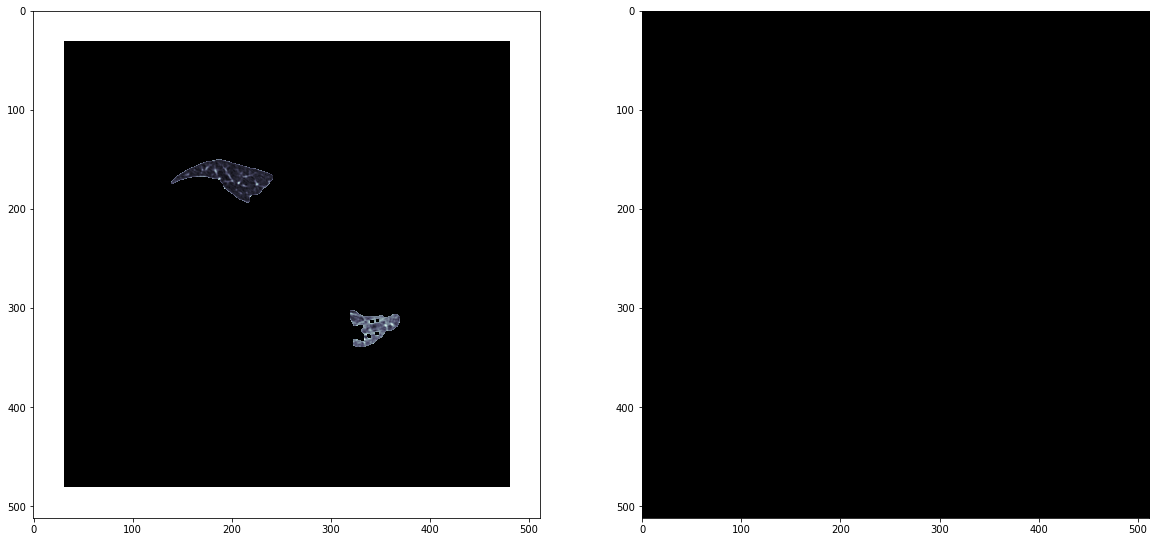

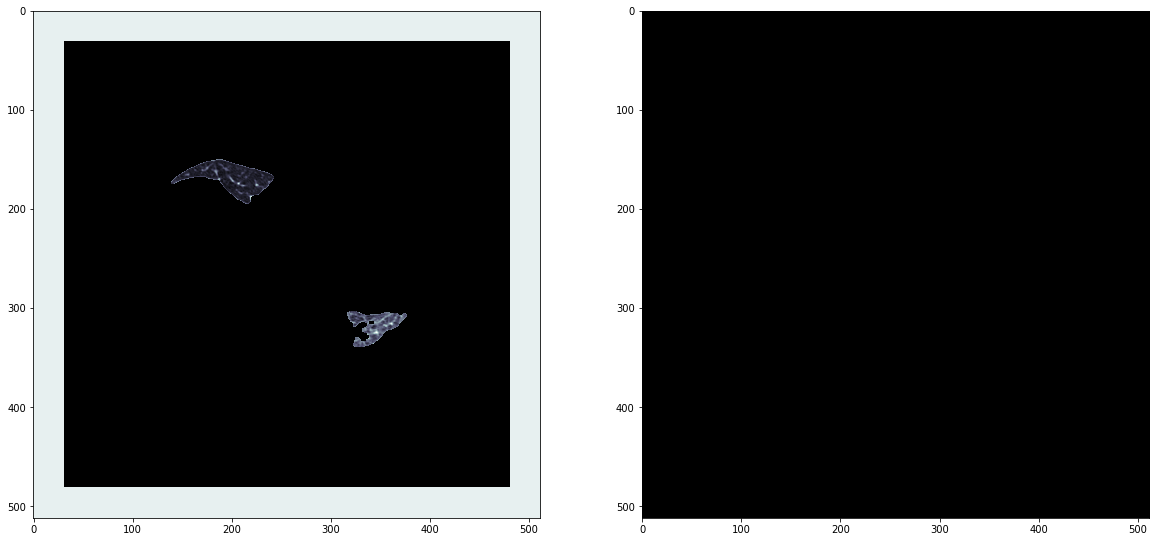

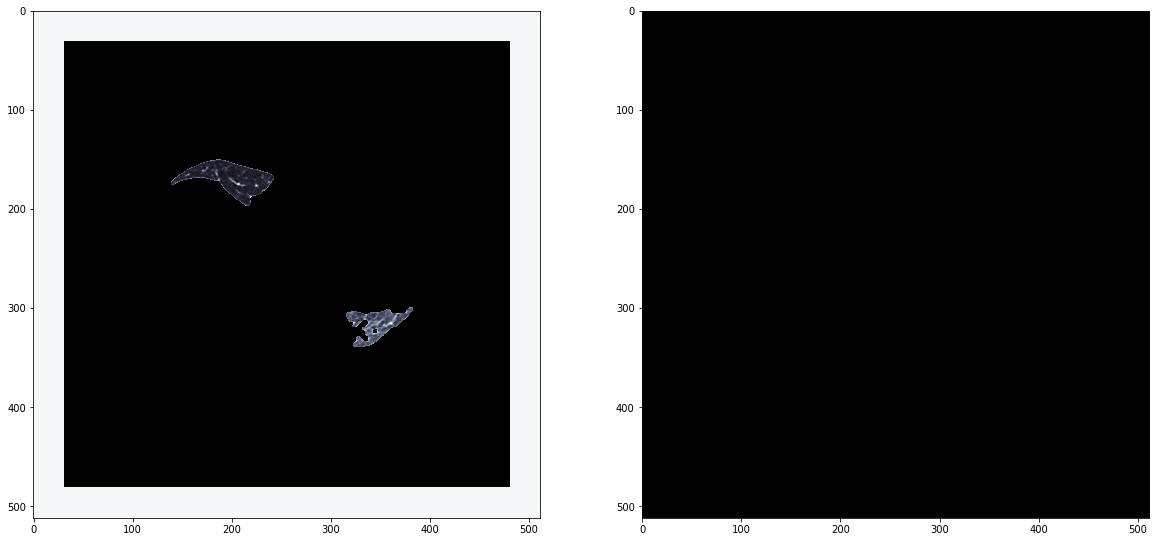

In [ ]:
for file in lung_train:
    #filename = file[:64] + '_nodule_mask.npz'
    filename = file[:64] + '.npz'
    if filename == '1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492':
        print("found")
        imgs_train = lung_train[file].value
        imgs_mask_train = nod_train[file].value
        break

for slice in imgs_train:
    for a_slice in imgs_mask_train:
        #Visualization
        x, y = plt.subplots(1, 2, figsize=[20,20])
        #y[0].set_title('Original Binary Image')
        y[0].imshow(slice, plt.cm.bone)
        #y[1].set_title('Denoised Image')
        y[1].imshow(a_slice, plt.cm.bone)
        #y[2].set_title('Labeled Image')
        #y[2].imshow(segmented, plt.cm.bone)
        #y[3].set_title('Segmented lungs')
        #y[3].imshow(slice, plt.cm.bone)
        #plt.show()
        break